<a href="https://colab.research.google.com/github/arjunparmar/VIRTUON/blob/main/Harshit/Warping_Module(GAN%20Trail).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade neural_structured_learning

     |████████████████████████████████| 122kB 9.2MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras.layers import Conv2D, concatenate, Dropout,MaxPool2D, MaxPooling2D, Conv2DTranspose, Activation, BatchNormalization,UpSampling2D, Add
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import neural_structured_learning as nsl

import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
im_height, im_width, im_channels = (128,128,3)
n_classes = 20
batch = 32

In [ ]:
#Build the model
def conv_2d_block (x,n_filters,k_size,batchnorm = False):
#1st layer
  x= Conv2D(filters=n_filters,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
    x= BatchNormalization()(x)
  x = Activation('relu')(x)
#2nd Layer
  x= Conv2D(filters=n_filters,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
    x= BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [ ]:
def clothing_encoder(inputs, n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):

  c1 = conv_2d_block(inputs,n_filters*1,conv_k_size,batchnorm)  
  p1 = MaxPool2D(pool_size=(pool_size,pool_size))(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv_2d_block(p1,n_filters*2,conv_k_size,batchnorm)  
  p2 = MaxPool2D(pool_size=(pool_size,pool_size))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_2d_block(p2,n_filters*4,conv_k_size,batchnorm)  
  p3 = MaxPool2D(pool_size=(pool_size,pool_size))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv_2d_block(p3,n_filters*8,conv_k_size,batchnorm)  
  p4 = MaxPool2D(pool_size=(pool_size,pool_size))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv_2d_block(p4,n_filters*16,conv_k_size,batchnorm)  
  p5 = MaxPool2D(pool_size=(pool_size,pool_size))(c5)
  p5 = Dropout(dropout)(p5)

  c6 = conv_2d_block(p5,n_filters*32,conv_k_size,batchnorm)  
  p6 = MaxPool2D(pool_size=(pool_size,pool_size))(c6)
  p6 = Dropout(dropout)(p6)

  c7 = conv_2d_block(p6,n_filters*64,conv_k_size,batchnorm)
 

  a =  tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="nearest")(c7)

  c8 = conv_2d_block(a,n_filters*32,conv_k_size,batchnorm)  


  return c8

In [ ]:
def pose_encoder(inputs, n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):

  c01 = conv_2d_block(inputs,n_filters*1,conv_k_size,batchnorm)  
  p01 = MaxPool2D(pool_size=(pool_size,pool_size))(c01)
  p01 = Dropout(dropout)(p01)
  
  c02 = conv_2d_block(p01,n_filters*2,conv_k_size,batchnorm)  
  p02 = MaxPool2D(pool_size=(pool_size,pool_size))(c02)
  p02 = Dropout(dropout)(p02)

  c03 = conv_2d_block(p02,n_filters*4,conv_k_size,batchnorm)  
  p03 = MaxPool2D(pool_size=(pool_size,pool_size))(c03)
  p03 = Dropout(dropout)(p03)

  c04 = conv_2d_block(p03,n_filters*8,conv_k_size,batchnorm)  
 

  c05 = conv_2d_block(c04,n_filters*16,conv_k_size,batchnorm)  
  

  c06 = conv_2d_block(c05,n_filters*32,conv_k_size,batchnorm)
 
  return c06

In [ ]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  
  # add the input 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x

def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x

In [ ]:
def res_block(x, s, filters):

  # input_im = Input(shape=(x.shape[1], x.shape[2], x.shape[3])) # cifar 10 images size
  # x = ZeroPadding2D(padding=(3, 3))(input_im)

  # # 1st stage
  # # here we perform maxpooling, see the figure above

  # x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)


  #2nd stage 
  # frm here on only conv block and identity block, no pooling
  x = res_conv(x, s, filters)
  x = res_identity(x, filters=(64, 512))
  x = res_identity(x, filters=(64, 512))

  # 3rd stage

  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))


  # 4th stage

  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))

  # 5th stage

  x = res_identity(x, filters=(512, 512))
  x = res_identity(x, filters=(512, 512))

  # ends with average pooling and dense connection

  # x = AveragePooling2D((2, 2), padding='same')(x)

  # x = Flatten()(x)
  # x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  return x

In [ ]:
#cloth decoder 
def clothing_decoder(inputs,n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):
  u6 = Conv2DTranspose(filters=n_filters *16 ,kernel_size=(3,3), strides=(2,2),padding='same')(inputs)
  u6 = Dropout(dropout)(u6)
  c7 = conv_2d_block(u6,n_filters *16 , conv_k_size,batchnorm)

  u7 = Conv2DTranspose(filters=n_filters *8,kernel_size=(3,3), strides=(2,2),padding='same')(c7)
  u7 = Dropout(dropout)(u7)
  c8 = conv_2d_block(u7,n_filters *8 , conv_k_size,batchnorm)

  u8 = Conv2DTranspose(filters=n_filters *4,kernel_size=(3,3), strides=(2,2),padding='same')(c8)
  u8 = Dropout(dropout)(u8)
  c9 = conv_2d_block(u8,n_filters *4, conv_k_size,batchnorm)

  c10 = Conv2D(filters=n_classes, kernel_size=(1,1),activation='softmax')(c9)
  
  return c10

In [ ]:
def warp(cloth_input, pose_input):
    cloth = clothing_encoder(cloth_input)
    pose = pose_encoder(pose_input)
    both = concatenate([cloth, pose])
    resnet = res_block(both, 1, (64,512))
    output = clothing_decoder(resnet)

    return Model(inputs = (cloth_input, pose_input), outputs = output, name = "Warping_Module")

In [ ]:
cloth = Input((im_height, im_width, n_classes), name = "cloth")
pose = Input((im_height, im_width, im_channels), name = 'pose')
test = warp(cloth, pose)

In [ ]:
test.summary()

Model: "Warping_Module"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cloth (InputLayer)              [(None, 128, 128, 20 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 2896        cloth[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [ ]:
x_train_pos = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/pos_train.npy")
x_train_seg = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/seg_train_argmax.npy")
x_valid_pos = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/x_test.npy")
x_valid_seg = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/seg_test_argmax.npy")

In [ ]:
x_train_seg_1 = tf.one_hot(x_train_seg, depth = n_classes)
x_valid_seg_1 = tf.one_hot(x_valid_seg, depth = n_classes)

In [ ]:
IMG_SIZE = 128

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
#   tf.keras.layers.experimental.preprocessing.RandomCrop(0.2,0.2)
])

In [ ]:
# plt.imshow(tf.math.argmax(data_augmentation(x_train_seg_1[10:11])[0], axis = -1))

In [ ]:
def preprocessing(pos, seg):
    seg_1 = data_augmentation(seg)
    pos = tf.image.resize(pos, [im_height, im_width])
    seg = tf.image.resize(seg, [im_height, im_width])
    return (seg_1, pos), seg

In [ ]:
def generator():
    while True:
        for i in range(0,len(x_train_pos),batch):
            if (i + batch < len(x_train_pos)):
                pos = x_train_pos[i:i+batch]
                seg = x_train_seg_1[i:i+batch]
                yield preprocessing(pos, seg)
            else:
                last = len(x_train_pos)
                pos = x_train_pos[i:last]
                seg = x_train_seg_1[i:last]
                yield preprocessing(pos, seg)

In [ ]:
def generator_valid():
    while True:
        for i in range(0,len(x_valid_pos),batch):
            if (i + batch < len(x_valid_pos)):
                pos = x_valid_pos[i:i+batch]
                seg = x_valid_seg_1[i:i+batch]
                yield preprocessing(pos, seg)
            else:
                last = len(x_valid_pos)
                pos = x_valid_pos[i:last]
                seg = x_valid_seg_1[i:last]
                yield preprocessing(pos, seg)

In [ ]:
train = generator()
valid = generator_valid()

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# def adversarial_loss(x , y, features = f, alpha = 0.5):      
#     labeled_loss = loss_fn(y, x)

#     adv_loss = nsl.keras.adversarial_loss(
#         f, y, test, loss_fn, labeled_loss=labeled_loss)
#     total_loss = labeled_loss + alpha*adv_loss

#     return total_loss

test.compile(optimizer=optimizer, loss = loss_fn, metrics = ['accuracy'])

In [ ]:
callback = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-7, verbose=1)
    ]

In [ ]:
test.fit(train,
         steps_per_epoch=900 // batch,
         epochs = 200,
         callbacks = callback,
         validation_data = valid,
         validation_steps = 100 // batch
         )

# for x, y in train():
#   with tf.GradientTape() as tape_w:

    
#     with tf.GradientTape() as tape_x:
#       tape_x.watch(x)

      
#       labeled_loss = loss_fn(y, model(x))


#     adv_loss = nsl.keras.adversarial_loss(
#         x, y, model, loss_fn, labeled_loss=labeled_loss, gradient_tape=tape_x)


#     total_loss = labeled_loss + adv_loss


#   gradients = tape_w.gradient(total_loss, model.trainable_variables)
#   optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 1/200
28/28 [==============================] - 17s 603ms/step - loss: 0.4242 - accuracy: 0.8644 - val_loss: 345.9565 - val_accuracy: 0.0563
Epoch 2/200
28/28 [==============================] - 17s 609ms/step - loss: 0.4211 - accuracy: 0.8654 - val_loss: 346.0612 - val_accuracy: 0.0563
Epoch 3/200
28/28 [==============================] - 17s 622ms/step - loss: 0.4220 - accuracy: 0.8653 - val_loss: 346.6885 - val_accuracy: 0.0563
Epoch 4/200
28/28 [==============================] - 18s 628ms/step - loss: 0.4229 - accuracy: 0.8650 - val_loss: 346.6072 - val_accuracy: 0.0563
Epoch 5/200
28/28 [==============================] - 17s 617ms/step - loss: 0.4233 - accuracy: 0.8650 - val_loss: 346.7598 - val_accuracy: 0.0563
Epoch 6/200
28/28 [==============================] - 17s 616ms/step - loss: 0.4228 - accuracy: 0.8649 - val_loss: 346.7477 - val_accuracy: 0.0563

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 7/200
28/28 [==============================] - 17s 61

In [ ]:
check = (tf.image.resize(x_train_seg_1[10:11], [128,128]), tf.image.resize(x_train_pos[0:1], [128,128]))

In [ ]:
result = test.predict(check)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


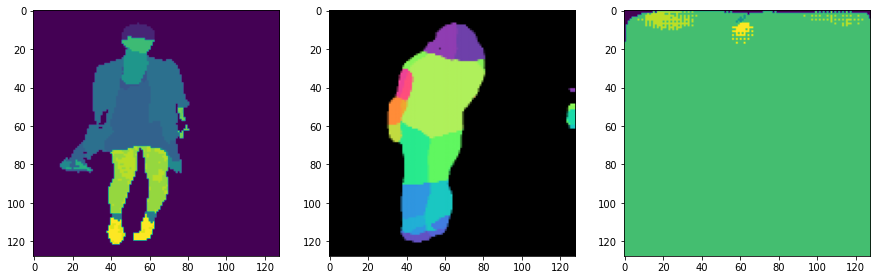

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (15,15))
axes[0].imshow(tf.math.argmax(tf.image.resize(x_train_seg_1[10:11], [128,128])[0], axis = -1))
axes[1].imshow(tf.image.resize(x_train_pos[0:1], [128,128])[0])
axes[2].imshow(tf.math.argmax(result[0], axis = -1))